# Importar librerías

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb

# Cargar datos y exploración inicial

(101613, 11)
step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065

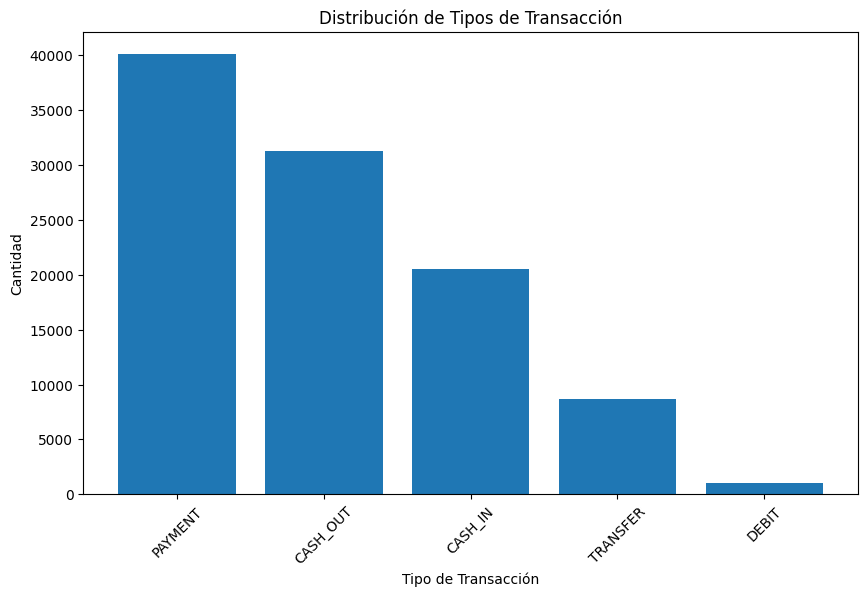

In [19]:
df = pd.read_csv('fraud.csv')

print(df.shape)
print(df.dtypes)
print(df.head())
print(df.describe())

# Gráfica de conteo de tipos de transacción
type_counts = df['type'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(type_counts.index, type_counts.values)
plt.title('Distribución de Tipos de Transacción')
plt.xlabel('Tipo de Transacción')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Contar la cantidad de datos con isFraud igual a 0 y 1
count_isFraud_0 = df[df['isFraud'] == 0].shape[0]
count_isFraud_1 = df[df['isFraud'] == 1].shape[0]

print(f'Número de instancias con isFraud = 0: {count_isFraud_0}')
print(f'Número de instancias con isFraud = 1: {count_isFraud_1}')


Número de instancias con isFraud = 0: 101497
Número de instancias con isFraud = 1: 116


In [4]:
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
101608,10,PAYMENT,7477.02,C513257306,785.00,0.00,M524833426,0.00,0.00,0,0
101609,10,CASH_OUT,282252.35,C210473293,220339.29,0.00,C1172042998,95156.01,91286.97,0,0
101610,10,PAYMENT,17289.01,C807582280,0.00,0.00,M334249577,0.00,0.00,0,0
101611,10,TRANSFER,1347146.45,C1315779140,1605.00,0.00,C1631408038,541639.43,2186953.43,0,0


# Exploración de datos más avanzada

# Manejar valores perdidos

In [21]:
missing_values = df.isnull().sum()
print("Valores perdidos por columna:")
print(missing_values)

df.dropna(inplace=True)

# Codificar variables categóricas
df = pd.get_dummies(df, columns=['type'])


Valores perdidos por columna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [22]:
df = df.drop(['step','nameOrig','nameDest'], axis=1)

In [23]:
df.columns

Index(['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'type_CASH_IN',
       'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

# Escalar/normalizar numéricas

In [24]:
# Seleccionar solo las columnas numéricas para el escalado
num_vars = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Inicializar el escalador
scaler = MinMaxScaler()

df[num_vars] = MinMaxScaler().fit_transform(df[num_vars])

In [25]:
# Balanceo de clases usando SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(df.drop('isFraud', axis=1), df['isFraud'])

# Crear un nuevo DataFrame con las variables escaladas y balanceadas
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=df.drop('isFraud', axis=1).columns), pd.Series(y_resampled, name='isFraud')], axis=1)


In [26]:
df_resampled

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,0.000984,0.004369,0.004116,0.000000,0.000000,0,0,0,0,1,0,0
1,0.000186,0.000546,0.000498,0.000000,0.000000,0,0,0,0,1,0,0
2,0.000018,0.000005,0.000000,0.000000,0.000000,0,0,0,0,0,1,1
3,0.000018,0.000005,0.000000,0.000623,0.000000,0,0,1,0,0,0,1
4,0.001167,0.001067,0.000767,0.000000,0.000000,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
202989,0.001259,0.000323,0.000000,0.000000,0.000000,0,0,0,0,0,1,1
202990,0.000249,0.000064,0.000000,0.000000,0.000000,0,0,0,0,0,1,1
202991,0.003321,0.000853,0.000000,0.000710,0.000127,0,0,1,0,0,0,1
202992,0.009791,0.002514,0.000000,0.000000,0.000000,0,0,0,0,0,1,1


# División de datos, entrenamiento y evaluación

In [58]:
# Separar las características y las etiquetas después del balanceo
X = df_resampled.drop('isFraud', axis=1)
y = df_resampled['isFraud']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [63]:
# Definir parámetros para XGBoost
params = {
    'eta': 0.01,
    'max_depth': 5,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'lambda': 1,
    'alpha': 0.1,
    'objective': 'binary:logistic',
    'n_estimators': 1000
}
# Crear y entrenar el modelo XGBoost con ajustes adicionales
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(
    X_train, y_train,
    eval_metric="auc",
    eval_set=[(X_train, y_train), (X_test, y_test)],
    early_stopping_rounds=50,
    verbose=10
)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.98102	validation_1-auc:0.97994
[10]	validation_0-auc:0.99251	validation_1-auc:0.99197
[20]	validation_0-auc:0.99380	validation_1-auc:0.99342
[30]	validation_0-auc:0.99377	validation_1-auc:0.99333
[40]	validation_0-auc:0.99424	validation_1-auc:0.99383
[50]	validation_0-auc:0.99460	validation_1-auc:0.99423
[60]	validation_0-auc:0.99483	validation_1-auc:0.99444
[70]	validation_0-auc:0.99496	validation_1-auc:0.99459
[80]	validation_0-auc:0.99518	validation_1-auc:0.99480
[90]	validation_0-auc:0.99517	validation_1-auc:0.99480
[100]	validation_0-auc:0.99529	validation_1-auc:0.99491
[110]	validation_0-auc:0.99558	validation_1-auc:0.99523
[120]	validation_0-auc:0.99575	validation_1-auc:0.99540
[130]	validation_0-auc:0.99597	validation_1-auc:0.99566
[140]	validation_0-auc:0.99614	validation_1-auc:0.99583
[150]	validation_0-auc:0.99615	validation_1-auc:0.99585
[160]	validation_0-auc:0.99628	validation_1-auc:0.99599
[170]	validation_0-auc:0.99649	validation_1-auc:0.99625
[18

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None,
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000, ...)

In [64]:
# Realizar predicciones en el conjunto de prueba
y_pred = xgb_model.predict(X_test)

# Evaluar el modelo
print('ROC AUC:', roc_auc_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

ROC AUC: 0.990426684561943
Precision: 0.9852477660438668
Recall: 0.9957635467980296
